# Fraiser Dialog Speaker Classification

### On a Raspberry Pi 3 (DietPi Buster image)

Data Source: https://www.kaggle.com/sulabhbista/frasier-dialogs/data#script.csv

Columns:
- url: URL from where the dialog was downloaded
- cast: Name of the cast
- dialog: Dialog utterance by the cast
- timestamp: Date/time when the a specific row was downloaded

Tasks:
- Explore the text data
  - E.g. Check the top words used by each speaker
- Balance classes, if applicable
- Tokenise the data and train a classifier to predict the speaker
 - Use pre-trained word embedding
 - Use own word embedding

In [12]:
import pandas as pd
import nltk
nltk.download('punkt')

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
df = pd.read_csv('./script.csv')
df.head()

,url,cast,dialog,timestamp
0,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[firmly] Listen to yourself, Bob! You follow ...",2018-04-13 07:43:16
1,http://www.kacl780.net/frasier/transcripts/sea...,Roz,"Yes, Dr Crane. On line four, we have Russell ...",2018-04-13 07:43:16
2,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[presses a button] Hello, Russell. This is Dr...",2018-04-13 07:43:16
3,http://www.kacl780.net/frasier/transcripts/sea...,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo...",2018-04-13 07:43:16
4,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"Er, Russell, we're just about at the end of ou...",2018-04-13 07:43:16


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 4 columns):
url          63945 non-null object
cast         63943 non-null object
dialog       63788 non-null object
timestamp    63945 non-null object
dtypes: object(4)
memory usage: 999.2+ KB


In [30]:
# dropping some unneeded columns

df.drop(columns=['url', 'timestamp'], inplace=True)
df.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
3,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."


In [31]:
# cleaning some NaN columns
df.dropna(inplace=True)

In [32]:
df['cast'].unique()

array(['Frasier', 'Roz', 'Russell', ...,
       'Rachel: You can do me one quick favor',
       'leaving is because I want what all of you have now', 'Pilot'],
      dtype=object)

In [33]:
# some cast values contain dialog, let's focus on cast with top 5 value_counts

main_cast_counts = df['cast'].value_counts()[:5]
main_cast_counts

Frasier    21088
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [34]:
df_main = df.loc[df['cast'].isin(main_cast_counts.keys())]
df_main.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."
5,Roz,"No, we cut to the news thirty seconds ago."


## Data Exploration and Imbalance Checking

In [35]:
# There are 2x more Fraiser lines than the 2nd highest (Niles).
# Let's try to balance the dataset by sampling from the Fraiser rows
# Before we do that, let's see what the average dialog length is for Fraiser

In [36]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenizer.tokenize)
tokens

0        [firmly, Listen, to, yourself, Bob, You, follo...
2        [presses, a, button, Hello, Russell, This, is,...
4        [Er, Russell, we're, just, about, at, the, end...
6        [annoyed, rips, off, his, headphones, Oh, for,...
7        [Well, the, rest, of, the, show, was, pretty, ...
9        [Roz, in, the, trade, we, call, that, avoidanc...
11       [I, am, not, a, piece, of, Lalique, I, can, ha...
13       [takes, the, notepaper, You, say, my, brother,...
17       [looks, up, Oh, I'm, sorry, Niles, I, didn't, ...
19       [Oh, Niles, you're, a, psychiatrist, you, know...
21                                                   [And]
23       [Yes, I, know, what, you, think, about, everyt...
26                            [Two, cafe, latte, supremos]
27                                        [No, thank, you]
29       [I'm, fine, I, love, my, new, life, I, love, t...
31       [So, does, he, laughs, The, fresh, air's, good...
33                                           [Is, it, Da

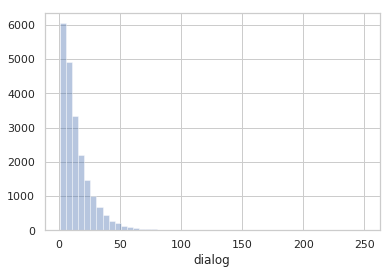

In [37]:
lengths = tokens.apply(len)
sns.distplot(lengths, kde=False)
plt.show()

In [38]:
lengths.describe()

count    21088.000000
mean        13.954097
std         13.583504
min          1.000000
25%          5.000000
50%         10.000000
75%         19.000000
max        250.000000
Name: dialog, dtype: float64

In [39]:
# capturing the above into a function
def plot_wordcount_distribution(cast, df_input):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes
    tokens = df_input.loc[df_input['cast'] == cast, 'dialog'].apply(tokenizer.tokenize)
    lengths = tokens.apply(len)
    sns.distplot(lengths, kde=False)
    plt.xlabel(cast)
    plt.show()
    return lengths.describe()

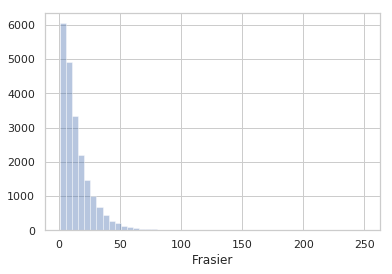

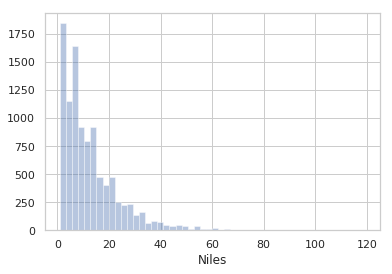

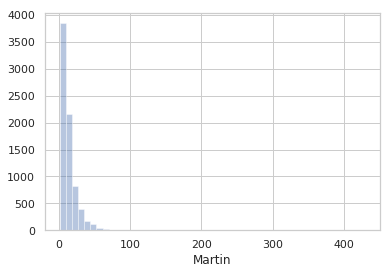

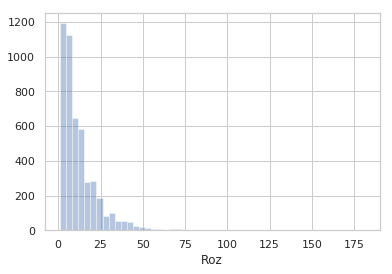

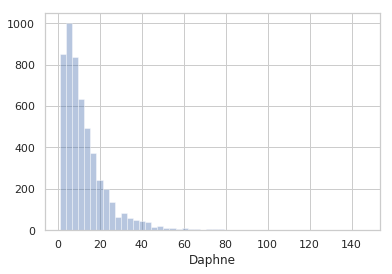

In [40]:
stats = pd.DataFrame({'Frasier': plot_wordcount_distribution('Frasier', df_main)})
stats = pd.concat([stats, pd.DataFrame({'Niles': plot_wordcount_distribution('Niles', df_main)})], axis=1) # col-wise concat
stats = pd.concat([stats, pd.DataFrame({'Martin': plot_wordcount_distribution('Martin', df_main)})], axis=1)
stats = pd.concat([stats, pd.DataFrame({'Roz': plot_wordcount_distribution('Roz', df_main)})], axis=1) 
stats = pd.concat([stats, pd.DataFrame({'Daphne': plot_wordcount_distribution('Daphne', df_main)})], axis=1)

In [41]:
# stats at a glance
stats

,Frasier,Niles,Martin,Roz,Daphne
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000
mean,13.954097,12.746512,12.874033,12.062302,12.732596
std,13.583504,11.720568,13.316791,11.796728,12.514220
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,4.000000,5.000000
50%,10.000000,9.000000,9.000000,9.000000,9.000000
75%,19.000000,17.000000,17.000000,16.000000,16.000000
max,250.000000,119.000000,429.000000,181.000000,146.000000


In [42]:
# 75% percentile is about 18-29 tokens
# The distributions are quite similar, so we will undersample from Frasier to balance the classes a bit more
# They don't have to be exactly the same.

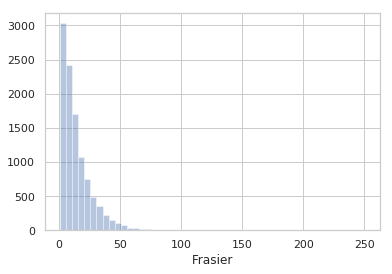

In [43]:
df_frasier_sampled = df_main.loc[df_main['cast'] == 'Frasier'].sample(frac=.5)

stats = pd.concat([stats, pd.DataFrame({'Frasier (sampled)': plot_wordcount_distribution('Frasier', df_frasier_sampled)})], axis=1)

In [44]:
# compare before and after undersampling.
stats

,Frasier,Niles,Martin,Roz,Daphne,Frasier (sampled)
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000,10544.000000
mean,13.954097,12.746512,12.874033,12.062302,12.732596,13.995827
std,13.583504,11.720568,13.316791,11.796728,12.514220,13.708237
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000
50%,10.000000,9.000000,9.000000,9.000000,9.000000,10.000000
75%,19.000000,17.000000,17.000000,16.000000,16.000000,19.000000
max,250.000000,119.000000,429.000000,181.000000,146.000000,250.000000


In [45]:
# create our dataset
df_main_balanced = df_frasier_sampled

cast = ['Niles', 'Martin', 'Roz', 'Daphne']
for c in cast:
    df_main_balanced = pd.concat([df_main_balanced, 
                                  df_main.loc[df_main['cast'] == c]])

In [46]:
df_main_balanced['cast'].value_counts()

Frasier    10544
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [47]:
# save a snapshot of our balanced dataframe
pickle.dump(df_main_balanced, open('./df_main_balanced.pkl', 'wb'))

## Tokenisation

In [10]:
df_main_balanced = pickle.load(open('./df_main_balanced.pkl', 'rb'))
df_main_balanced.head()

,cast,dialog
28808,Frasier,"Look, let's just drop it, all right? All's we..."
62283,Frasier,"Yes, I am. I have a small practice here in to..."
22236,Frasier,I don't hear anything?
61897,Frasier,"Trust me, you are comically incorrect. I do n..."
5337,Frasier,Are you done?


In [13]:
X = df_main_balanced['dialog']

le_y = LabelEncoder()
y = le_y.fit_transform(df_main_balanced['cast'])
y = tf.keras.utils.to_categorical(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.1,
                                                    random_state=42)

In [53]:
# Tokenise, limiting to most frequent 5000 words
max_vocab_length = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_length, filters='')
tokenizer.fit_on_texts(X_train)

# Create sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Set seq length to 75th percentile
seq_length = 20

# Pad sequences with pre-padding so that activations will be non-zero towards end of sequence
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=seq_length, 
                                                            padding='pre')
X_train_seq.shape, X_train_seq

((34496, 20), array([[   0,    0, 1328, ...,   10,    5,  843],
        [   0,    0,    0, ...,    5,  285,  377],
        [   0,    0,    0, ...,  190,  172,  160],
        ...,
        [   0,    0,    0, ...,   67,   40,   20],
        [   0,    0,    0, ...,  169,   31,  473],
        [   0,    0,    0, ...,    0,   21,  277]]))

In [54]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=seq_length,
                                                           padding='pre')
X_test_seq.shape, X_test_seq

((3833, 20), array([[   0,    0,    0, ...,   86,  129,  387],
        [   0,    0,    0, ...,    0,    0,  342],
        [   0,    0,    0, ...,   22,   32, 3219],
        ...,
        [  26,  207,   21, ...,    3,  619,  278],
        [   0,    0,    0, ...,    1,   73,  197],
        [   0,    0,    0, ...,  106,  436,  228]]))

## Model Engineering

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime

In [67]:
# Simple CNN model with non-pre-trained Embedding
cnn_simple = Sequential()
cnn_simple.add(Embedding(max_vocab_length+1, 50, input_length=seq_length))
cnn_simple.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn_simple.add(Flatten())
cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dense(5, activation='softmax'))
cnn_simple.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 50)            250050    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 32)            8032      
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 291,239
Trainable params: 291,239
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_dir = os.path.join('./logs', 'fraiser', 'cnn_simple',
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_cnn_simple.h5', save_best_only=True)

cnn_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_simple.fit(X_train_seq, y_train, validation_split=.2,
               batch_size=64, epochs=25, callbacks=[tb, mc])

Train on 27596 samples, validate on 6900 samples
Epoch 1/25
27596/27596 [==============================] - 46s 2ms/sample - loss: 1.0499 - accuracy: 0.5873 - val_loss: 1.2712 - val_accuracy: 0.4899
Epoch 2/25
27596/27596 [==============================] - 43s 2ms/sample - loss: 0.8553 - accuracy: 0.6725 - val_loss: 1.4001 - val_accuracy: 0.4694
Epoch 3/25
27596/27596 [==============================] - 39s 1ms/sample - loss: 0.6791 - accuracy: 0.7447 - val_loss: 1.5957 - val_accuracy: 0.4536
Epoch 4/25
27596/27596 [==============================] - 39s 1ms/sample - loss: 0.5423 - accuracy: 0.7943 - val_loss: 1.8674 - val_accuracy: 0.4429
Epoch 5/25
27596/27596 [==============================] - 39s 1ms/sample - loss: 0.4516 - accuracy: 0.8265 - val_loss: 2.1842 - val_accuracy: 0.4261
Epoch 6/25
 3584/27596 [==>...........................] - ETA: 32s - loss: 0.3554 - accuracy: 0.8708